In [18]:
!pip install torch_geometric rdkit pubchempy -q

In [19]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax

import os.path as osp
from math import sqrt

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from tqdm import trange
import sys

import matplotlib.pyplot as plt
import numpy as np

In [20]:
class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr="add", node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(
        self,
        x_j: Tensor,
        x_i: Tensor,
        edge_attr: Tensor,
        index: Tensor,
        ptr: OptTensor,
        size_i: Optional[int],
    ) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """

    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim, dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(
                hidden_channels,
                hidden_channels,
                dropout=dropout,
                add_self_loops=False,
                negative_slope=0.01,
            )
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(
            hidden_channels,
            hidden_channels,
            dropout=dropout,
            add_self_loops=False,
            negative_slope=0.01,
        )
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs2 = torch.nn.ModuleList()
        self.atom_grus2 = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(
                hidden_channels,
                hidden_channels,
                dropout=dropout,
                add_self_loops=False,
                negative_slope=0.01,
            )
            self.atom_convs2.append(conv)
            self.atom_grus2.append(GRUCell(hidden_channels, hidden_channels))

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(
        self, x: Tensor, edge_index: Tensor, edge_attr: Tensor, batch: Tensor
    ) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            # print(f"Before: {h.shape}")
            h = conv(x, edge_index)
            # print(f"after: {h.shape}")
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (
            f"{self.__class__.__name__}("
            f"in_channels={self.in_channels}, "
            f"hidden_channels={self.hidden_channels}, "
            f"out_channels={self.out_channels}, "
            f"edge_dim={self.edge_dim}, "
            f"num_layers={self.num_layers}, "
            f"num_timesteps={self.num_timesteps}"
            f")"
        )

In [21]:
class GenFeatures:
    def __init__(self):
        self.symbols = [
            "B",
            "C",
            "N",
            "O",
            "F",
            "Si",
            "P",
            "S",
            "Cl",
            "As",
            "Se",
            "Br",
            "Te",
            "I",
            "At",
            "other",
        ]

        self.hybridizations = [
            Chem.rdchem.HybridizationType.SP,
            Chem.rdchem.HybridizationType.SP2,
            Chem.rdchem.HybridizationType.SP3,
            Chem.rdchem.HybridizationType.SP3D,
            Chem.rdchem.HybridizationType.SP3D2,
            "other",
        ]

        self.stereos = [
            Chem.rdchem.BondStereo.STEREONONE,
            Chem.rdchem.BondStereo.STEREOANY,
            Chem.rdchem.BondStereo.STEREOZ,
            Chem.rdchem.BondStereo.STEREOE,
        ]

    def __call__(self, data):
        # Generate AttentiveFP features according to Table 1.
        mol = Chem.MolFromSmiles(data.smiles)

        xs = []
        for atom in mol.GetAtoms():
            symbol = [0.0] * len(self.symbols)
            symbol[self.symbols.index(atom.GetSymbol())] = 1.0
            degree = [0.0] * 6
            degree[atom.GetDegree()] = 1.0
            formal_charge = atom.GetFormalCharge()
            radical_electrons = atom.GetNumRadicalElectrons()
            hybridization = [0.0] * len(self.hybridizations)
            hybridization[self.hybridizations.index(atom.GetHybridization())] = 1.0
            aromaticity = 1.0 if atom.GetIsAromatic() else 0.0
            hydrogens = [0.0] * 5
            hydrogens[atom.GetTotalNumHs()] = 1.0
            chirality = 1.0 if atom.HasProp("_ChiralityPossible") else 0.0
            chirality_type = [0.0] * 2
            if atom.HasProp("_CIPCode"):
                chirality_type[["R", "S"].index(atom.GetProp("_CIPCode"))] = 1.0

            x = torch.tensor(
                symbol
                + degree
                + [formal_charge]
                + [radical_electrons]
                + hybridization
                + [aromaticity]
                + hydrogens
                + [chirality]
                + chirality_type
            )
            xs.append(x)

        data.x = torch.stack(xs, dim=0)

        edge_indices = []
        edge_attrs = []
        for bond in mol.GetBonds():
            edge_indices += [[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]]
            edge_indices += [[bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]]

            bond_type = bond.GetBondType()
            single = 1.0 if bond_type == Chem.rdchem.BondType.SINGLE else 0.0
            double = 1.0 if bond_type == Chem.rdchem.BondType.DOUBLE else 0.0
            triple = 1.0 if bond_type == Chem.rdchem.BondType.TRIPLE else 0.0
            aromatic = 1.0 if bond_type == Chem.rdchem.BondType.AROMATIC else 0.0
            conjugation = 1.0 if bond.GetIsConjugated() else 0.0
            ring = 1.0 if bond.IsInRing() else 0.0
            stereo = [0.0] * 4
            stereo[self.stereos.index(bond.GetStereo())] = 1.0

            edge_attr = torch.tensor(
                [single, double, triple, aromatic, conjugation, ring] + stereo
            )

            edge_attrs += [edge_attr, edge_attr]

        if len(edge_attrs) == 0:
            data.edge_index = torch.zeros((2, 0), dtype=torch.long)
            data.edge_attr = torch.zeros((0, 10), dtype=torch.float)
        else:
            data.edge_index = torch.tensor(edge_indices).t().contiguous()
            data.edge_attr = torch.stack(edge_attrs, dim=0)

        return data


path = osp.join("data", "AFP_Mol")
dataset = MoleculeNet(path, name="ESOL", pre_transform=GenFeatures()).shuffle()

N = len(dataset) // 10
val_dataset = dataset[:N]
test_dataset = dataset[N : 2 * N]
train_dataset = dataset[2 * N :]

train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000)
test_loader = DataLoader(test_dataset, batch_size=1000)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentiveFP(
    in_channels=39,
    hidden_channels=200,
    out_channels=1,
    edge_dim=10,
    num_layers=2,
    num_timesteps=2,
    dropout=0.2,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=10**-2.5, weight_decay=10**-5)


def train():
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_examples += data.num_graphs
    return sqrt(total_loss / total_examples)


@torch.no_grad()
def test(loader):
    mse = []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        mse.append(F.mse_loss(out, data.y, reduction="none").cpu())
    return float(torch.cat(mse, dim=0).mean().sqrt())

In [22]:
for epoch in (pbar := trange(1, 801, ncols=100)):
    train_rmse = train()
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    pbar.set_postfix({"train": train_rmse, "val": val_rmse, "test": test_rmse})
    # print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} Val: {val_rmse:.4f} '
    #       f'Test: {test_rmse:.4f}')

100%|█████████████████████████| 499/499 [00:46<00:00, 10.66it/s, train=0.344, val=0.663, test=0.617]


112


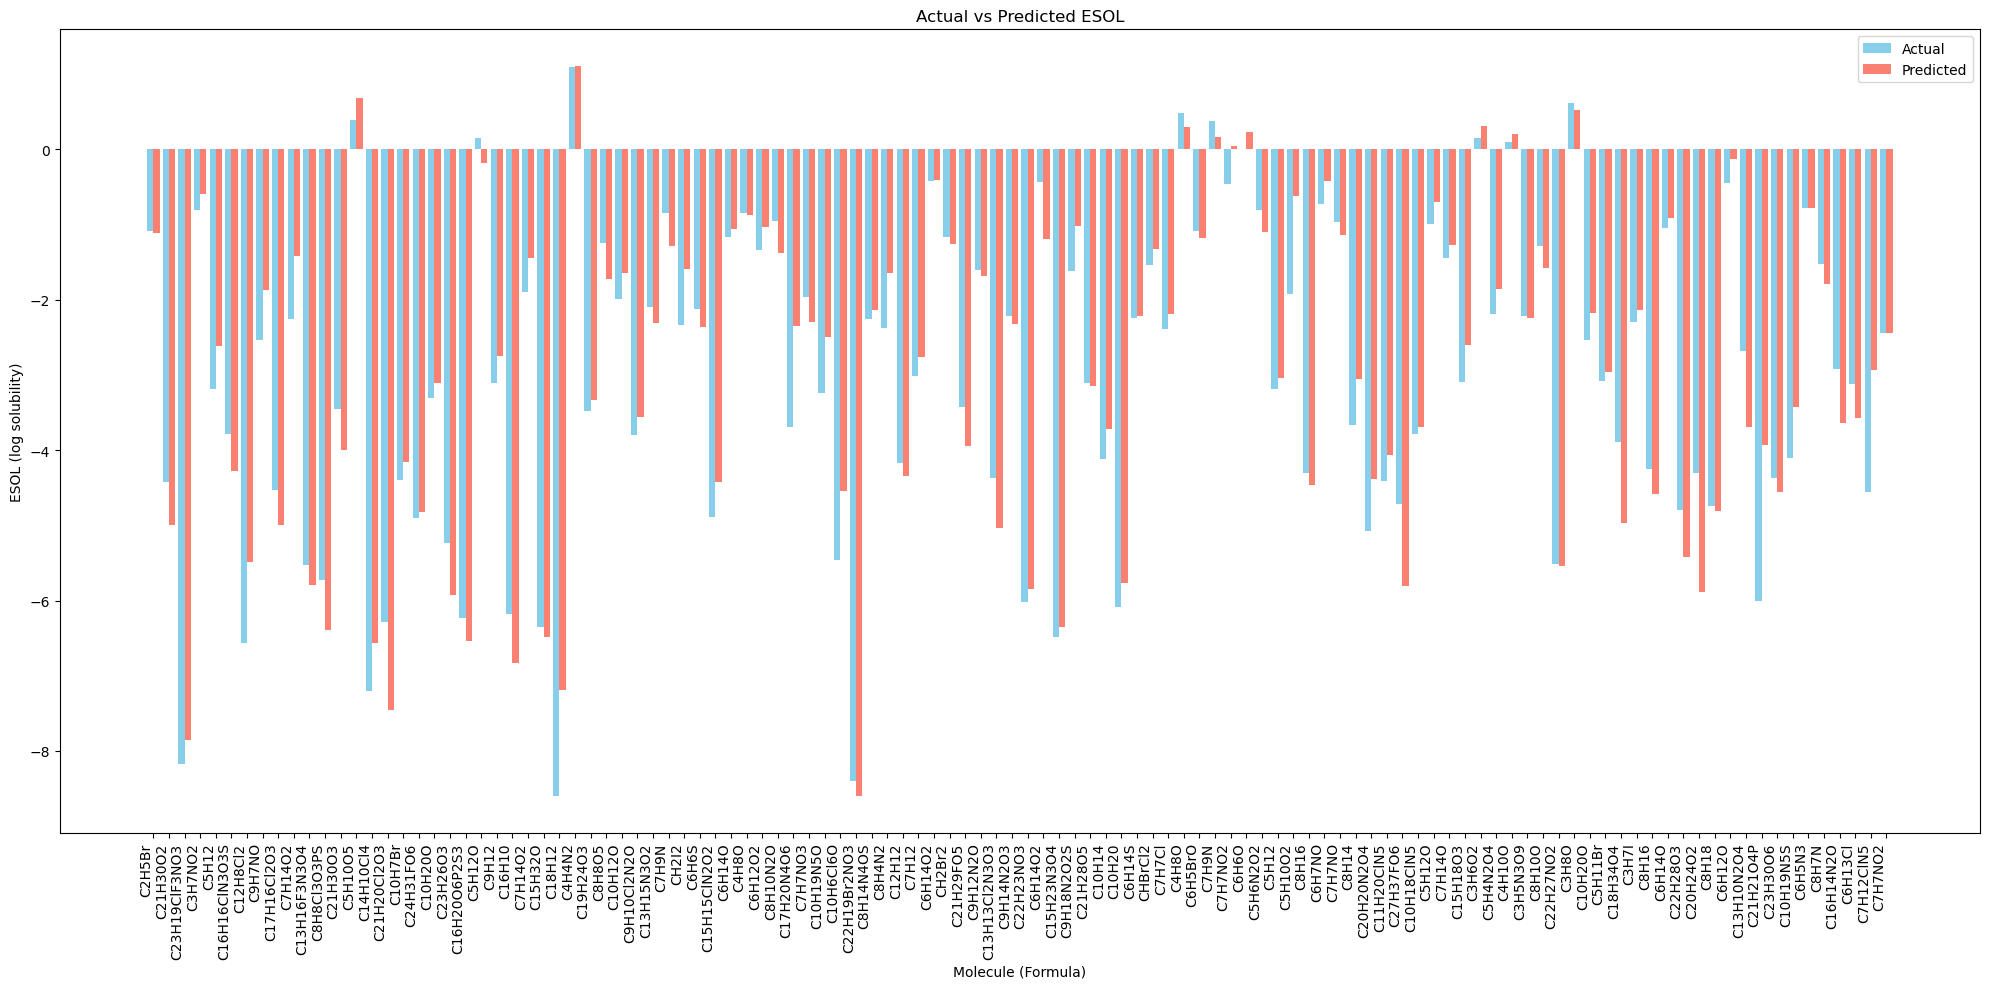

In [43]:
@torch.no_grad()
def predict(loader):
    y_true = []
    y_pred = []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        y_true.append(data.y.cpu())
        y_pred.append(out.cpu())
    return torch.cat(y_true, dim=0), torch.cat(y_pred, dim=0)



y_true, y_pred = predict(test_loader)


y_true = y_true.squeeze().numpy()
y_pred = y_pred.squeeze().numpy()


smiles_list = [data.smiles for data in test_dataset]


num_of_data = len(smiles_list)
#num_of_data = 40
print(len(smiles_list))

# Convert SMILES to molecular formula
mol_formulas = []
for smiles in smiles_list[:num_of_data]:
    mol = Chem.MolFromSmiles(smiles)
    formula = rdMolDescriptors.CalcMolFormula(mol) if mol else "Unknown"
    mol_formulas.append(formula)


indices = np.arange(num_of_data)
bar_width = 0.4

plt.figure(figsize=(20, 10))
plt.bar(indices - bar_width/2, y_true[:num_of_data], width=bar_width, label='Actual', color='skyblue')
plt.bar(indices + bar_width/2, y_pred[:num_of_data], width=bar_width, label='Predicted', color='salmon')

# plt.xticks(indices, mol_formulas, rotation=45, ha='right', fontsize=10)
plt.xticks(indices, mol_formulas, rotation=90, ha='right', fontsize=10)
plt.xlabel("Molecule (Formula)")
plt.ylabel("ESOL (log solubility)")
plt.title("Actual vs Predicted ESOL")
plt.legend()
plt.tight_layout()
plt.show()

In [51]:
import pubchempy as pcp

# for formula in mol_formulas:
#     print(formula)

# for smile in smiles_list:
#     print(smile)
mol_names = []
for smiles in smiles_list:
    try:
        mol = Chem.MolFromSmiles(smiles)
        molformula = rdMolDescriptors.CalcMolFormula(mol) if mol else "Unknown"
        if mol:
            # Convert SMILES to PubChem compound
            compounds = pcp.get_compounds(smiles, namespace='smiles')
            if compounds:
                print(f"{smiles} → {compounds[0].iupac_name} (common name: {compounds[0].synonyms[0]})")
                if len(compounds[0].synonyms[0]) > 30:
                    mol_names.append(molformula)
                else:
                    mol_names.append(compounds[0].synonyms[0])
            else:
                print(f"{smiles} → No match found")
                mol_names.append(f"Mol: {molformula}, No pubchempy name found")
        else:
            print(f"{smiles} → Invalid SMILES")
            mol_names.append(f"Smile: {smiles}, invalid")
    except Exception as e:
        print(f"{smiles} → Error: {e}")
        mol_names.append(f"Smile: {smiles}, error")

CCBr → bromoethane (common name: Bromoethane)
CC(=O)C1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C → 17-acetyl-10,13-dimethyl-1,2,6,7,8,9,11,12,14,15,16,17-dodecahydrocyclopenta[a]phenanthren-3-one (common name: 1-acetyl-9a,11a-dimethyl-1H,2H,3H,3aH,3bH,4H,5H,7H,8H,9H,9aH,9bH,10H,11H,11aH-cyclopenta[a]phenanthren-7-one)
CC1(C)C(C=C(Cl)C(F)(F)F)C1C(=O)OC(C#N)c2cccc(Oc3ccccc3)c2 → [cyano-(3-phenoxyphenyl)methyl] 3-(2-chloro-3,3,3-trifluoroprop-1-enyl)-2,2-dimethylcyclopropane-1-carboxylate (common name: [cyano-(3-phenoxyphenyl)methyl] 3-(2-chloro-3,3,3-trifluoroprop-1-enyl)-2,2-dimethylcyclopropane-1-carboxylate)
CCCN(=O)=O → 1-nitropropane (common name: 1-NITROPROPANE)
CCCCC → pentane (common name: PENTANE)
CC2Nc1cc(Cl)c(cc1C(=O)N2c3ccccc3C)S(N)(=O)=O  → 7-chloro-2-methyl-3-(2-methylphenyl)-4-oxo-1,2-dihydroquinazoline-6-sulfonamide (common name: metolazone)
Clc1ccc(cc1)c2ccc(Cl)cc2  → 1-chloro-4-(4-chlorophenyl)benzene (common name: 4,4'-Dichlorobiphenyl)
Oc1cccc2ncccc12  → quinolin-5-ol (common n

In [52]:
# for moleculename in mol_names:
#     print(moleculename)

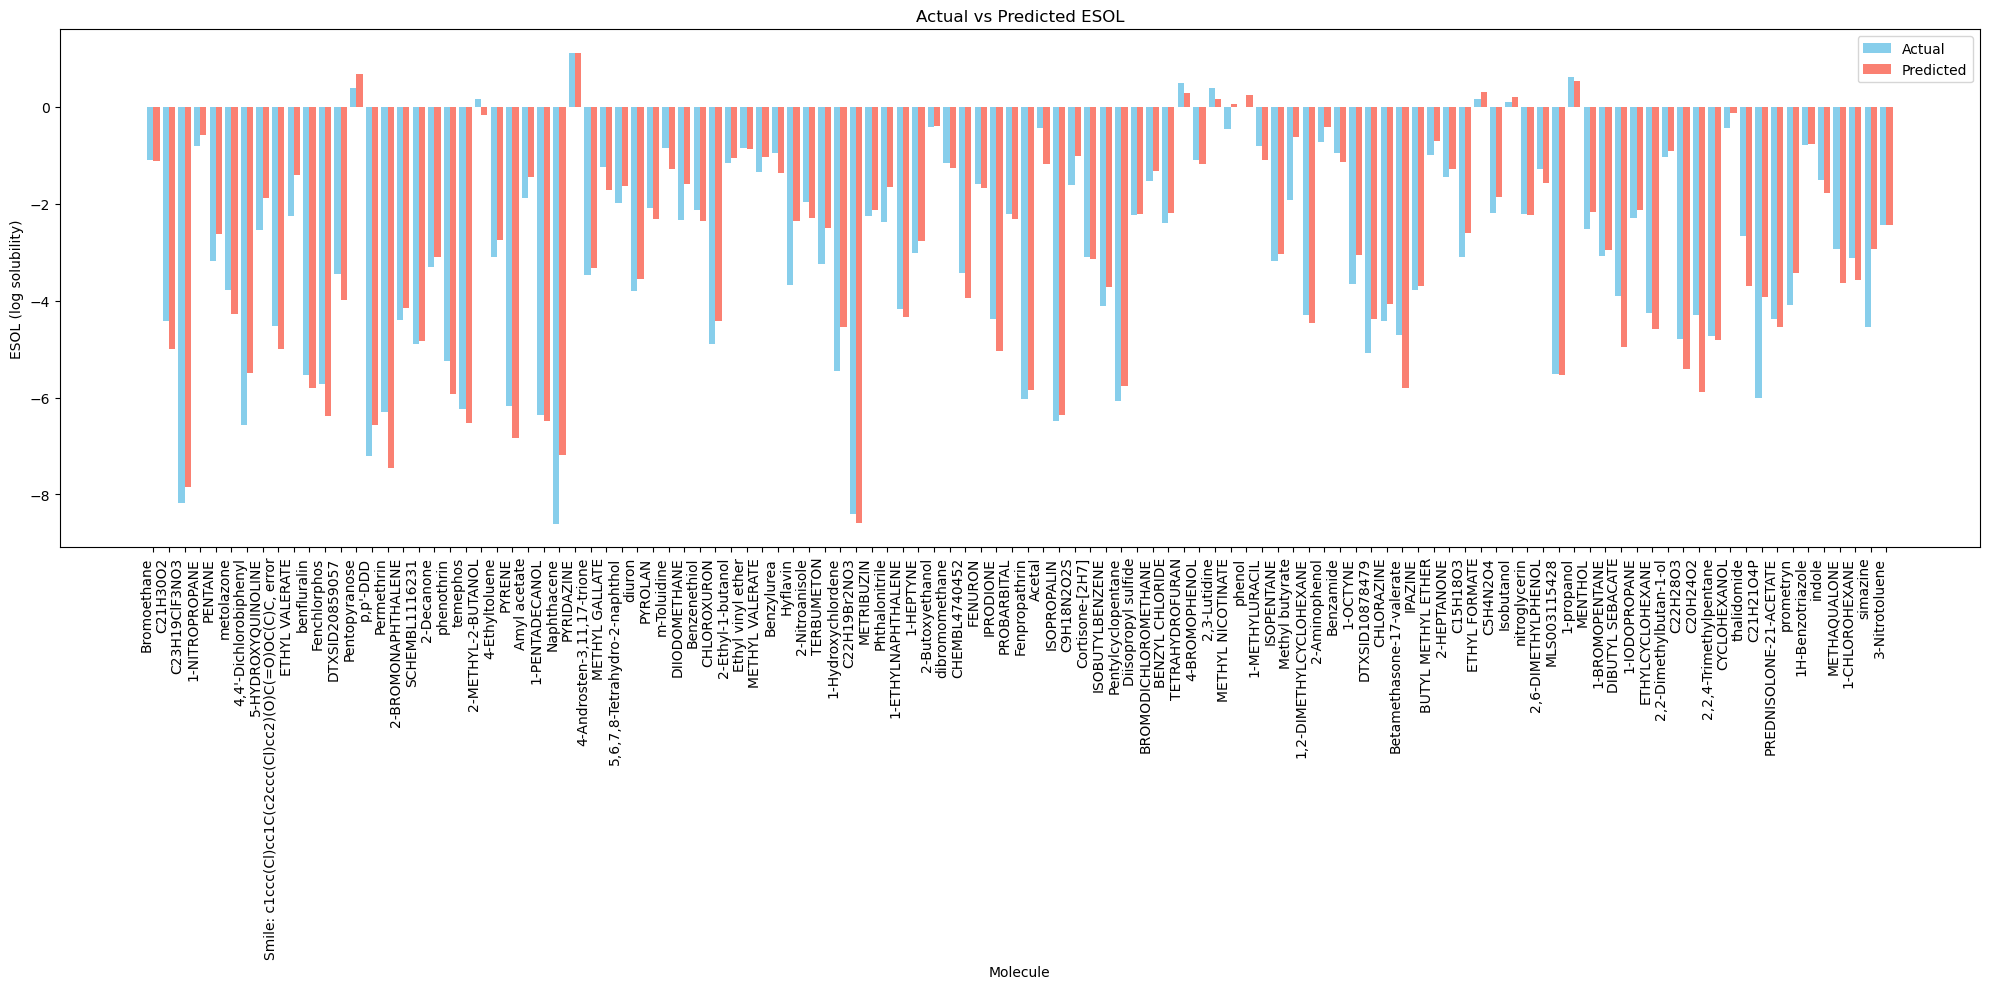

In [53]:


plt.figure(figsize=(20, 10))
plt.bar(indices - bar_width/2, y_true[:num_of_data], width=bar_width, label='Actual', color='skyblue')
plt.bar(indices + bar_width/2, y_pred[:num_of_data], width=bar_width, label='Predicted', color='salmon')

# plt.xticks(indices, mol_formulas, rotation=45, ha='right', fontsize=10)
plt.xticks(indices, mol_names, rotation=90, ha='right', fontsize=10)
plt.xlabel("Molecule")
plt.ylabel("ESOL (log solubility)")
plt.title("Actual vs Predicted ESOL")
plt.legend()
plt.tight_layout()
plt.show()